In [6]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from process_probe_data import retreive_plasma_current, retreive_magnetic_signal,trim_quantities

from tqdm import tqdm
from toroidalFilament.plasma_shift import cal_shift
from toroidalFilament.DxDz import cal_newton_DxDz as newton
from toroidalFilament.geometry_TT1 import cross, cross_perfect
from toroidalFilament import signal_strength

In [33]:
#retreive processed data
recorded_plasma_current, recorded_time, discharge_begin, discharge_end = retreive_plasma_current(966)
recorded_magnetic_signal = retreive_magnetic_signal(966)

time, plasma_current, plasma_signal = trim_quantities(recorded_time,recorded_magnetic_signal,recorded_plasma_current,discharge_begin,375)

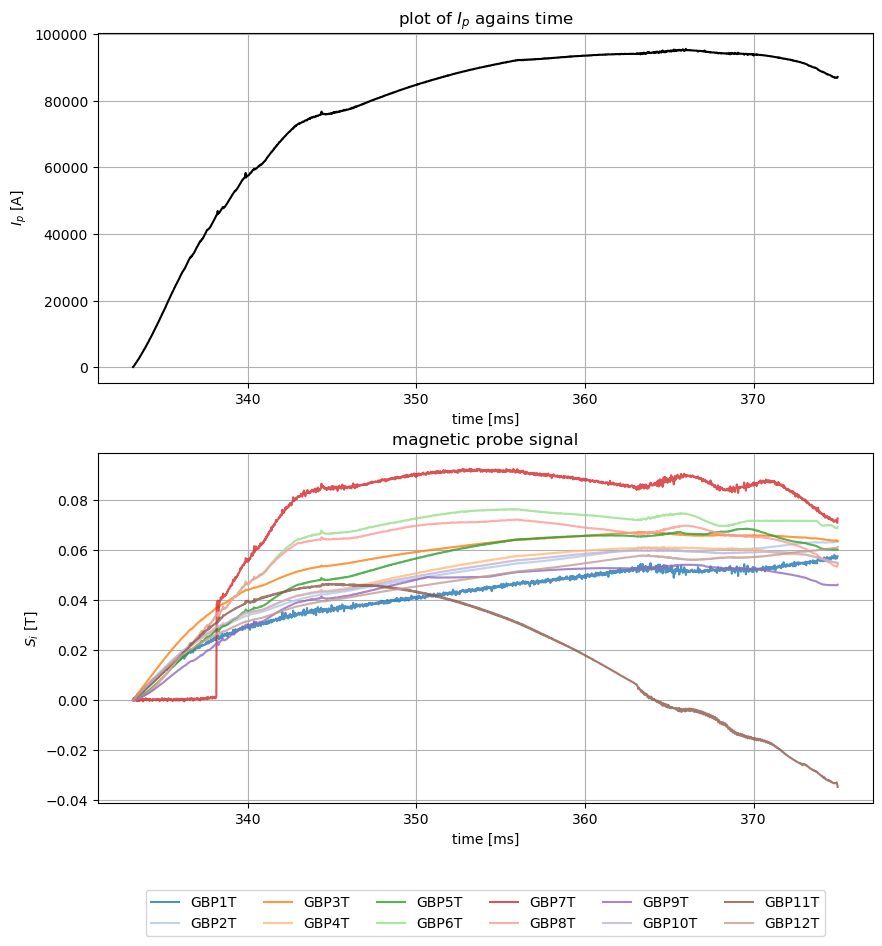

In [34]:
column_names = plasma_signal.columns[1:]


fig, (ax0,ax2) = plt.subplots(2,1, figsize = (10,10))
ax0.plot(time, plasma_current,color = "black")
ax0.set_xlabel("time [ms]")
ax0.set_ylabel("$I_p$ [A]")
ax0.grid()
ax0.set_title("plot of $I_p$ agains time")

cmap = plt.get_cmap("tab20")  # A colormap with 10 distinct colors

for i, name in enumerate(column_names):
    ax2.plot(time, plasma_signal[name], label=name, color=cmap(i),alpha = 0.8)
ax2.set_xlabel("time [ms]")
ax2.set_ylabel("$S_i$ [T]")
ax2.grid()
ax2.set_title("magnetic probe signal")
ax2.legend(loc = "lower center", bbox_to_anchor = (0.5,-0.4), ncol = 6)

In [61]:
#calculate experimental plasma shift
def experimental_toroidal_filament(time_exp,signal_exp,crosses,taylor_order = 2):
    #determine how many arrays are used
    num_result = len(crosses)

    #create blank lists for appendind results
    R0_arr, R0_err_arr = [[0] for _ in range(num_result)], [[0]for _ in range(num_result)]
    Z0_arr,Z0_err_arr = [[0]for _ in range(num_result)], [[0]for _ in range(num_result)]
    valid_time = [[0] for _ in range(num_result)]

    for t, signal in tqdm(zip(
        time_exp.to_numpy(),signal_exp.to_numpy()
    ),total = len(time_exp)):
        try:
            #retreive signals for each probe arrays
            signal_arr = []
            for arr in crosses:
                signal_arr.append(
                    [signal[coil_index] for coil_index in arr]
                )

            #calculate shift for each crosses
            for i,s in enumerate(signal_arr):
                shift = cal_shift(DxDz_method=newton, taylor_order=taylor_order,signal = s, 
                                est_horizontal_shift=R0_arr[i][-1], est_vertical_shift=Z0_arr[i][-1],coil_angle=crosses[i],
                                alpha_vertical_range=np.linspace(-0.05,0.05,101), beta_horizontal_range=np.linspace(-0.05,0.05,101))
                
                R_shift, R_err = shift[0]
                Z_shift, Z_err = shift[1]

                R0_arr[i].append(R_shift)
                R0_err_arr[i].append(R_err)
                Z0_arr[i].append(Z_shift)
                Z0_err_arr[i].append(Z_err)
            
                #time with valid shift values
                valid_time[i].append(t)

        except RuntimeError:
            continue
    
    return np.array(valid_time), np.array(R0_arr), np.array(R0_err_arr), np.array(Z0_arr), np.array(Z0_err_arr)

valid_time, R0_arr, R0_err, Z0_arr, Z0_err = experimental_toroidal_filament(time,plasma_signal,[[1,4,7,10]])

  0%|          | 0/2091 [00:00<?, ?it/s]c:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\toroidalFilament\DxDz.py:21: RuntimeWarning: invalid value encountered in scalar divide
  frac1, frac2 = (signal[0] - signal[2])/(signal[0] + signal[2]), (signal[1] - signal[3])/(signal[1] + signal[3])
  0%|          | 6/2091 [00:00<01:22, 25.25it/s]c:\Users\pitit\Documents\02_MUIC_programming\ICPY_441_Senior_project_in_physics\plasmaColumnPosition\toroidalFilament\signal_strength.py:56: UserWarning: horizontal shift beyond domain use a_f = R0
  warnings.warn("horizontal shift beyond domain use a_f = R0")
100%|██████████| 2091/2091 [00:58<00:00, 35.60it/s]


(-0.2, 0.2)

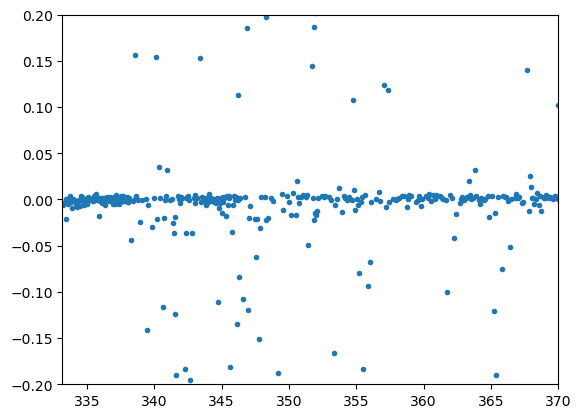

In [63]:
plt.plot(valid_time[0],R0_arr[0],".")
plt.xlim(discharge_begin,370)
plt.ylim(-0.2,0.2)